## Fit autocovariance

Objective : Estimate tides paramters by fitting a model to Eulerian and Lagrangian binned covariance of the demodulated velocity field

Several parameters of the fitting method can be testing.
Here we focus on a least-square method.

1) Basic method :

Model : $\tilde V e^{-\tau/\tilde T}cos(\omega\tau)$ ; with $\tilde V$ the variance, $\tilde T$ the incoherence timescale and $\omega = \frac{\omega_{S2}-\omega_{M2}}{2}$ fixed the spring neap cycle frequency over 2 (oscilations caused by demodulation)

No bounds, no first guess for the estimates, same weight at all timelag

2) Bounds imposed

3) More weight on the shortest timelags (20days) and a lot on the first. First guess for $\tilde V$ fixed at the autocovariance at timelag 0

In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr
import scipy.optimize
#import mitequinox.sigp as sp

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

from inspect import signature
import scipy

In [2]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

In [3]:
omega_sn = (omega_S2-omega_M2)/2

print('Spring-neap cycle : ', 1/(2*omega_sn), 'days')
print('Oscillation after demodulation ( spring-neap cycle /2): ', 1/omega_sn, 'days')

Spring-neap cycle :  14.765294045749723 days
Oscillation after demodulation ( spring-neap cycle /2):  29.530588091499446 days


In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,**kwargs):
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat_bins',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,**kwargs,
           cbar_kwargs={'fraction':0.02})
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    return fig,ax

In [5]:
#root_path = '/home/datawork-lops-osi/equinox/jetn/'
root_path = '/Users/zcaspar/codes/mit4320/'
#low :
file_E = root_path +'Ecov_SSU_low_mean0_dl2.nc'
file_L = root_path +'Lcov_SSU_low_mean0_dl2.nc'

dsE_low = xr.open_dataset(file_E)
dsL_low = xr.open_dataset(file_L)
low_dl2 = xr.open_dataset(root_path+'energy_binned_dl2.0.nc').rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'}) # Energy, 2°bins
low_var_dl2 = xr.open_dataset(root_path+'variance_SSU_binned_dl2.0.nc').rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'}) # Energy, 2°bins

#tide
file_E = root_path +'binned_Ecov_uu_dl2.nc'
file_L = root_path +'binned_Lcov_uu_dl2_flag10.nc'
file_L_T80 = root_path +'binned_Lcov_uu_dl2_flag10_T80.nc'
file_E_T80 = root_path +'Ecov_SSU_T80_dl2.nc'

dsE = xr.open_dataset(file_E)
dsL = xr.open_dataset(root_path+'Lcov_SSU_dl2.nc') #file_L
dsE_SSV = xr.open_dataset(root_path +'binned_Ecov_vv_dl2.nc')
dsL_SSV = xr.open_dataset(root_path +'binned_Lcov_vv_dl2_flag10.nc')

dsL_80 = xr.open_dataset(file_L_T80)
dsE_80 = xr.open_dataset(file_E_T80)

hf_dl1 = xr.merge([xr.open_dataset(root_path+'energy_%s_binned_dl1.0.nc'% i).rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'}
                                                                                   ) for i in ['SSU','SSV']])
hf_dl2 = xr.open_dataset(root_path+'energy_SSU_binned_dl2.0.nc').rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'})
# Tidal variance, 2°bins

dsE_Eta = xr.open_dataset(root_path+'Ecov_Eta_dl2.nc')


#path = '/Users/zcaspar/codes/Diagnostics/'+run#local


In [6]:
dsE = xr.merge([dsE.rename({'rr':'rr_SSU','ri':'ri_SSU'}),
                dsE_SSV.rename({'rr':'rr_SSV','ri':'ri_SSV'})])

dsL = xr.merge([dsL.rename({'rr':'rr_SSU','ri':'ri_SSU','ii':'ii_SSU'}),
                dsL_SSV.rename({'rr':'rr_SSV','ri':'ri_SSV'})])
dsL

<xarray.Dataset>
Dimensions:   (lat_bins: 59, lon_bins: 179, lags: 961)
Coordinates:
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lags      (lags) float64 0.0 0.04167 0.08333 0.125 ... 39.92 39.96 40.0
Data variables:
    rr_SSU    (lat_bins, lon_bins, lags) float64 ...
    ri_SSU    (lat_bins, lon_bins, lags) float64 ...
    ii_SSU    (lat_bins, lon_bins, lags) float64 ...
    count     (lat_bins, lon_bins) float64 0.0 1.0 0.0 0.0 ... 14.0 11.0 14.0
    rr_SSV    (lat_bins, lon_bins, lags) float64 ...
    ri_SSV    (lat_bins, lon_bins, lags) float64 ...

In [7]:
dsE = dsE.where(dsE.rr_SSU.sel(lags=0))
dsL = dsL.where(dsL.rr_SSU.sel(lags=0))

In [8]:
dt = 3/24 # time step in days
rad = 2*np.pi
tau = np.arange(0,dsL.lags.max()+dt,dt) #time lag
tau80 = np.arange(0,dsL_80.lags.max()+dt,dt) #time lag

In [9]:
def fit_function(y,t=None,myfunc=None,first_guess='free',bounds=None,sigma=None):
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        y : data to fit
        t : timelag of the correlation function
        myfunc : function we want to fit to our data, y
        p0 : first guess on parameters
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        params : parameters for which we obtain the best fit
        error : covariance of params computed in scipy.optimize.curve_fit
        yfit : best fit
        """
    sig = signature(myfunc)
    len_sig = len(sig.parameters.keys())
    try : 
        if first_guess=='lag' and sigma is None:
            _p0 = np.full(len_sig-1,1)
            _p0[-1] = y[0]
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000)
    #    try:
        if sigma is not None:
            if first_guess=='lag':
                _p0 = np.full(len_sig-1,1)
                _p0[-1] = y[0]
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
            else:
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
        else:
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000)
        yfit = myfunc(t,*[p for p in params])
        error=np.sqrt(np.diag(cov))
    except:
#        print("error")
        params,error = np.full(len_sig-1,np.nan),np.full(len_sig-1,np.nan)
        yfit = np.full_like(t,np.nan)
#        out = xr.Dataset({'params':(['lat_bins','lon_bins','param'],np.expand_dims(params, axis=0)),
#                      'fitted':(['lat_bins','lon_bins','lags'],np.expand_dims(yfit,axis=0)),
#                     'error' : (['lat_bins','lon_bins','param'],np.expand_dims(cov,axis=0))},
 #                    coords={'lat_bins':np.array([y.lat_bins.values]),'lon_bins':np.array([y.lon_bins.values])
 #                            ,'param':[V for V in sig.parameters.keys()][1:],
 #                            'lags':y.lags.values})
    return params,error,yfit
def wrapper(ds,v,myfunc,t,bounds,p0='free',sigma=None):
    sig = signature(myfunc)
    params_name = [V for V in sig.parameters.keys()][1:]
    kwargs={'t':t,'myfunc':myfunc,'first_guess':p0,'bounds':bounds}
    if sigma is not None:
        kwargs.update({'sigma':sigma})
        
    print('Parameters to estimate:',params_name)
    params,error,yfit = xr.apply_ufunc(fit_function,ds[v],input_core_dims=[['lags']],
                                   output_core_dims=[['param'],['param'],['lags']],
                                   vectorize=True,kwargs=kwargs)
    params = params.rename('parameters').assign_coords({'param':params_name})
    error = error.rename('error').assign_coords({'param':params_name})
    ds_out = xr.merge([params,error,yfit])
#    ds_out = ds_out.where(ds_out[v].isel(lags=0)>1e-18)
    return ds_out

In [10]:
#dsL = dsL_80.isel(lags=slice(0,int(40*24+24/9),3))
dsL = dsL.isel(lags=slice(0,None,3))
dsL

<xarray.Dataset>
Dimensions:   (lat_bins: 59, lon_bins: 179, lags: 321)
Coordinates:
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lags      (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0
Data variables:
    rr_SSU    (lat_bins, lon_bins, lags) float64 nan nan ... -0.0002552
    ri_SSU    (lat_bins, lon_bins, lags) float64 nan nan ... -0.0004139
    ii_SSU    (lat_bins, lon_bins, lags) float64 nan nan ... 0.0002616 0.0002871
    count     (lat_bins, lon_bins) float64 0.0 1.0 0.0 0.0 ... 14.0 11.0 14.0
    rr_SSV    (lat_bins, lon_bins, lags) float64 nan nan ... 0.0001015 0.0001135
    ri_SSV    (lat_bins, lon_bins, lags) float64 nan nan ... -0.0004687

/var/folders/8p/ctkm_wt55j54lh09mdw3yv0r00g___/T/ipykernel_2866/3198679852.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/8p/ctkm_wt55j54lh09mdw3yv0r00g___/T/ipykernel_2866/3198679852.py:33: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


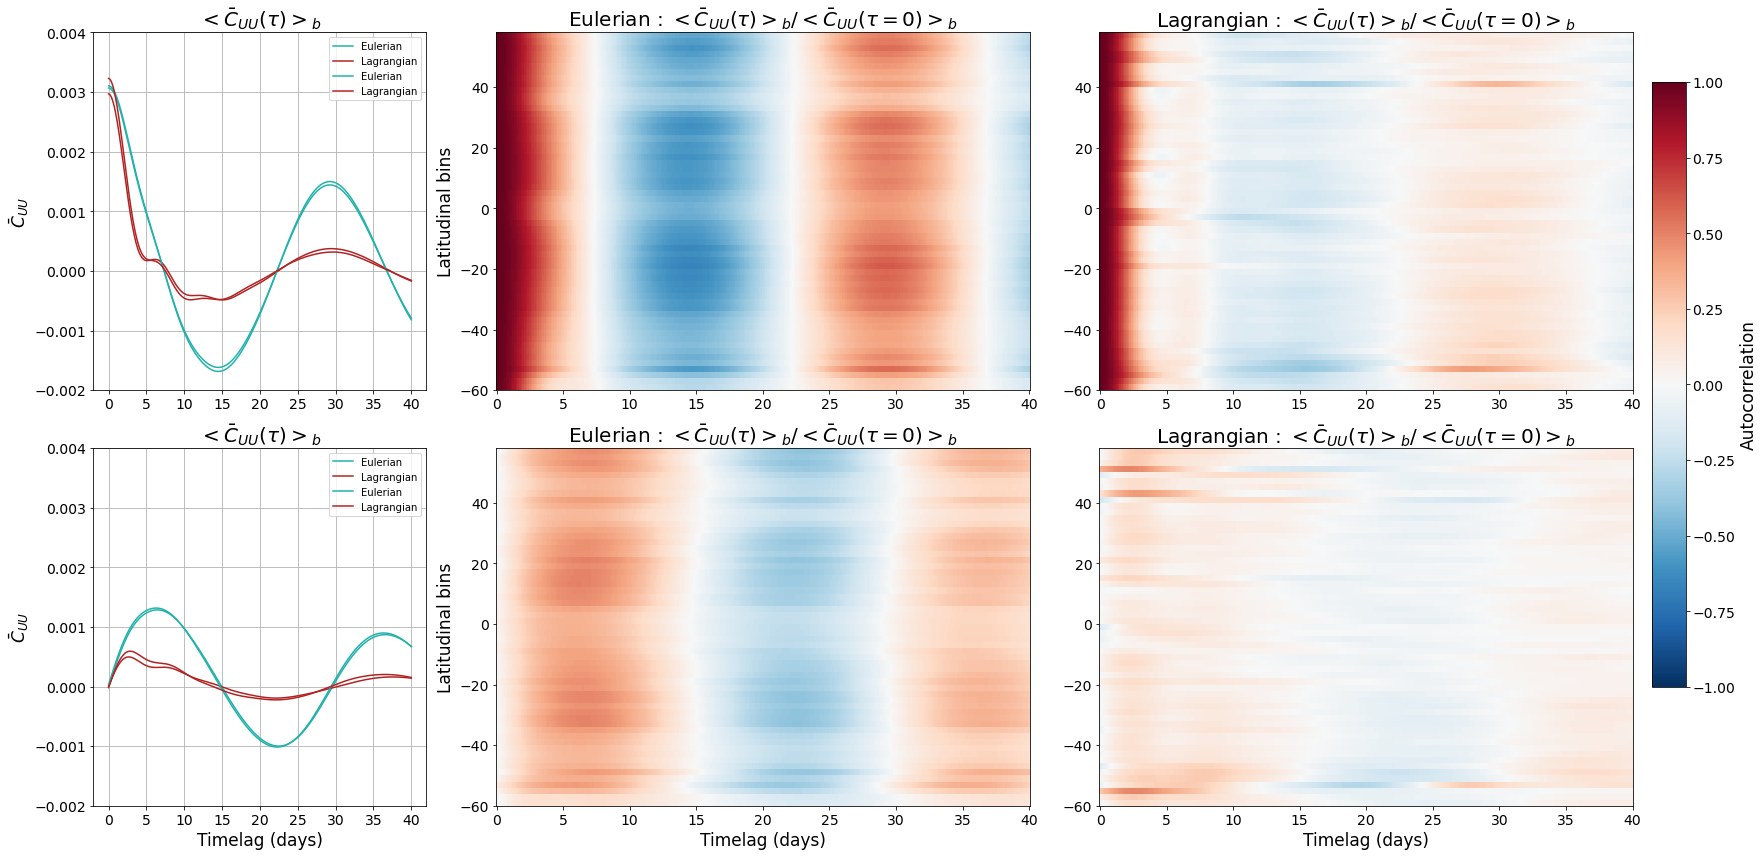

In [84]:
import matplotlib as mpl
with mpl.rc_context({'axes.titlesize': 20,'axes.labelsize':17,'xtick.labelsize':14,'ytick.labelsize':14}):
    fig = plt.figure(figsize=(23, 12), constrained_layout=True)
    spec = fig.add_gridspec(2, 8)

    for i,v in enumerate(['rr_SSU','ri_SSU']):
        ax = fig.add_subplot(spec[i, 2:5])
        comp = v[-1]
        cs = (dsE[v].mean('lon_bins')/dsE['rr_SSU'].mean('lon_bins').isel(lags=0)
        ).plot(cmap='RdBu_r',ax=ax,y='lat_bins',vmax=1,vmin=-1,add_colorbar=False);
        ax.set_title(r'Eulerian : $<\bar C_{%s%s}(\tau)>_b/<\bar C_{%s%s}(\tau=0)>_b$'%(v[-1],v[-1],v[-1],v[-1]));
        ax.set_ylabel('Latitudinal bins');ax.set_xlabel('')
        ax1 = fig.add_subplot(spec[i, 5:],sharex=ax)
        (dsL[v].mean('lon_bins')/dsL['rr_SSU'].mean('lon_bins').isel(lags=0)
        ).plot(cmap='RdBu_r',ax=ax1,y='lat_bins',vmax=1,vmin=-1,add_colorbar=False);
        ax1.set_title(r'Lagrangian : $<\bar C_{%s%s}(\tau)>_b/<\bar C_{%s%s}(\tau=0)>_b$'%(v[-1],v[-1],v[-1],v[-1]));
        ax1.set_ylabel('');ax1.set_xlabel('')
        ax2 = fig.add_subplot(spec[i, :2])
        dsE[v].mean(['lon_bins','lat_bins']).plot(ax=ax2,ylim=(-0.002,0.004),c='lightseagreen',label='Eulerian');
        dsL[v].mean(['lon_bins','lat_bins']).plot(ax=ax2,ylim=(-0.002,0.004),c='firebrick',label='Lagrangian');
        
        dsE[v[:-1]+'V'].mean(['lon_bins','lat_bins']).plot(ax=ax2,ylim=(-0.002,0.004),c='lightseagreen',label='Eulerian');
        dsL[v[:-1]+'V'].mean(['lon_bins','lat_bins']).plot(ax=ax2,ylim=(-0.002,0.004),c='firebrick',label='Lagrangian');
        
        ax2.set_title(r'$<\bar C_{%s%s}(\tau)>_b$'%(v[-1],v[-1]));
        ax2.set_ylabel(r'$\bar C_{%s%s}$'%(v[-1],v[-1]));
        ax2.grid();ax2.legend();ax2.set_xlabel('')
    ax1.set_xlabel('Timelag (days)');ax.set_xlabel('Timelag (days)');ax2.set_xlabel('Timelag (days)')
    cbar_ax = fig.add_axes([1., 0.2, 0.02, 0.7])
    cb = fig.colorbar(cs, cax=cbar_ax)#
    cb.set_label('Autocorrelation',size=17)
    #annotate_axes(ax0, 'ax0')
fig.tight_layout()

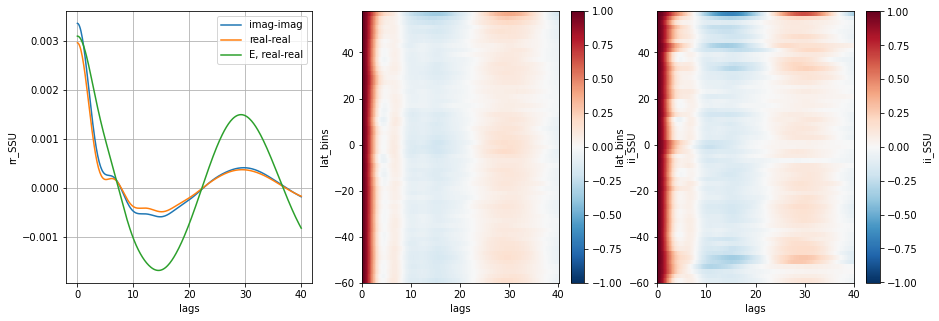

In [32]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
dsL.ii_SSU.mean(['lon_bins','lat_bins']).plot(ax=ax[0],label='imag-imag')
(dsL.ii_SSU/dsL.ii_SSU.sel(lags=0)).mean(['lon_bins']).plot(ax=ax[1])
(dsL.ii_SSU.mean(['lon_bins'])/dsL.ii_SSU.sel(lags=0).mean(['lon_bins'])).plot(ax=ax[2])
dsL.rr_SSU.mean(['lon_bins','lat_bins']).plot(ax=ax[0],label='real-real')
dsE.rr_SSU.mean(['lon_bins','lat_bins']).plot(ax=ax[0],label='E, real-real')
ax[0].legend();ax[0].grid()

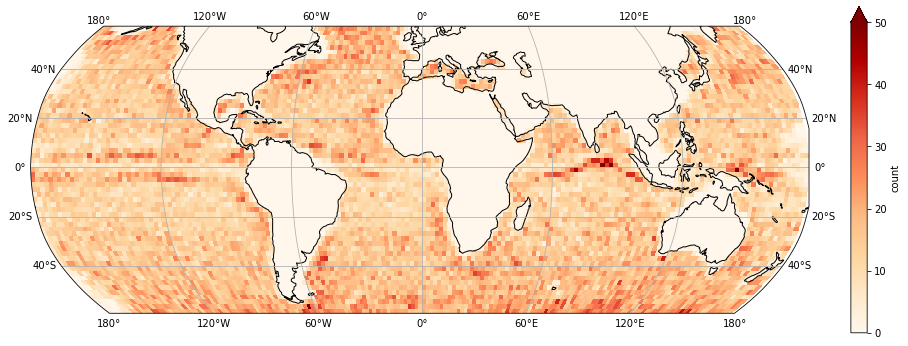

In [43]:
fig = plt.figure(figsize=(15,6))
fig,axs = plot_maps(dsL['count'],colmap='OrRd',vlim=(0,50))

In [12]:
def y_fit(tau,U,T):
    return U*np.exp(-tau/T)*np.cos(rad*omega_sn*tau)
def y_fit_mixed(tau,U,T,r):
    return U*(r+(1-r)*np.exp(-tau/T))*np.cos(rad*omega_sn*tau)

def y_fit_ri(tau,U,T):
    return U*np.exp(-tau/T)*np.sin(rad*omega_sn*tau)
def y_gauss(tau,U,T):
    return U*np.exp(-((tau)/T)**2)*np.cos(rad*omega_sn*tau)
def y_gauss_ri(tau,U,T):
    return U*np.exp(-((tau)/T)**2)*np.sin(rad*omega_sn*tau)

### Autocovariance and cross covariance separated
Both covairacne are fitted separatly

In [15]:
sigma = np.ones(tau.size)*1.
sigma[:int(20/dt)] = 0.5
#sigma[0] = 0.1

In [16]:
#V = dsE.sel(lags=0).rr_SSU
dsE_out = wrapper(dsE,'rr_SSU',y_fit,tau,sigma=sigma,bounds=(0,1000))
#V = dsL.sel(lags=0).rr_SSU
dsL_out = wrapper(dsL,'rr_SSU',y_fit,tau,sigma=sigma,bounds=(0,1000))
#dsL_out_gauss = wrapper(dsL,'rr_SSU',y_gauss,tau,sigma=sigma,bounds=([2.5,0],[1000,np.inf]))

Parameters to estimate: ['U', 'T']
Parameters to estimate: ['U', 'T']


In [17]:
dsE_out_gauss = wrapper(dsE,'rr_SSU',y_gauss,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))
dsL_out_gauss = wrapper(dsL,'rr_SSU',y_gauss,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))

Parameters to estimate: ['U', 'T']
Parameters to estimate: ['U', 'T']


In [18]:
dsEV_out = wrapper(dsE,'rr_SSV',y_fit,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))
dsLV_out = wrapper(dsL,'rr_SSV',y_fit,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))
dsEV_out_gauss = wrapper(dsE,'rr_SSV',y_gauss,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))
dsLV_out_gauss = wrapper(dsL,'rr_SSV',y_gauss,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))

Parameters to estimate: ['U', 'T']
Parameters to estimate: ['U', 'T']
Parameters to estimate: ['U', 'T']
Parameters to estimate: ['U', 'T']


In [19]:
dsE_out_ri = wrapper(dsE,'ri_SSU',y_fit_ri,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))
dsL_out_ri = wrapper(dsL,'ri_SSU',y_fit_ri,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))

Parameters to estimate: ['U', 'T']
Parameters to estimate: ['U', 'T']


In [20]:
dsE_out_gauss_ri = wrapper(dsE,'ri_SSU',y_gauss_ri,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))
dsL_out_gauss_ri = wrapper(dsL,'ri_SSU',y_gauss_ri,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))

Parameters to estimate: ['U', 'T']
Parameters to estimate: ['U', 'T']


In [21]:
dsEV_out_ri = wrapper(dsE,'ri_SSV',y_fit_ri,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))
dsLV_out_ri = wrapper(dsL,'ri_SSV',y_fit_ri,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))

dsEV_out_gauss_ri = wrapper(dsE,'ri_SSV',y_gauss_ri,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))
dsLV_out_gauss_ri = wrapper(dsL,'ri_SSV',y_gauss_ri,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))

Parameters to estimate: ['U', 'T']
Parameters to estimate: ['U', 'T']
Parameters to estimate: ['U', 'T']
Parameters to estimate: ['U', 'T']


In [44]:
#dsE_out_ii = wrapper(dsE,'rr_SSU',y_gauss,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))
dsL_out_gauss_ii = wrapper(dsL,'ii_SSU',y_gauss,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))
dsL_out_ii = wrapper(dsL,'ii_SSU',y_fit,tau,sigma=sigma,bounds=([0,0],[np.inf,1000]))

Parameters to estimate: ['U', 'T']
Parameters to estimate: ['U', 'T']


In [65]:
def plot_parameters(dsE, dsL,p,cmap='viridis',vmax=None):
    fig,axs = plt.subplots(1,3,figsize=(21,6))
    dsE.sel(param=p).parameters.plot(y='lat_bins',vmax=vmax,ax=axs[0],cmap=cmap)
    dsL.sel(param=p).parameters.plot(y='lat_bins',vmax=vmax,ax=axs[1],cmap=cmap)
    (dsL/dsE).sel(param=p).parameters.plot(y='lat_bins',vmax=2,ax=axs[2],cmap='RdBu_r')
    return fig,axs
def plot_comparison(ds0, ds1,p,bins):
    fig,axs = plt.subplots(1,2,figsize=(18,6))
    (ds0[0]/ds1[0]).sel(param=p).parameters.plot(y='lat_bins',vmax=2,ax=axs[0],cmap='RdBu_r')
    (ds0[1]/ds1[1]).sel(param=p).parameters.plot(y='lat_bins',vmax=2,ax=axs[1],cmap='RdBu_r')
    fig,axs = plt.subplots(1,2,figsize=(18,6))
    (ds0[0]/ds1[0]).sel(param=p).parameters.plot.hist(ax=axs[0],bins=bins)
    (ds0[1]/ds1[1]).sel(param=p).parameters.plot.hist(ax=axs[1],bins=bins)
    return fig,axs

Text(0.5, 0.98, 'Gaussian model, real-imag')

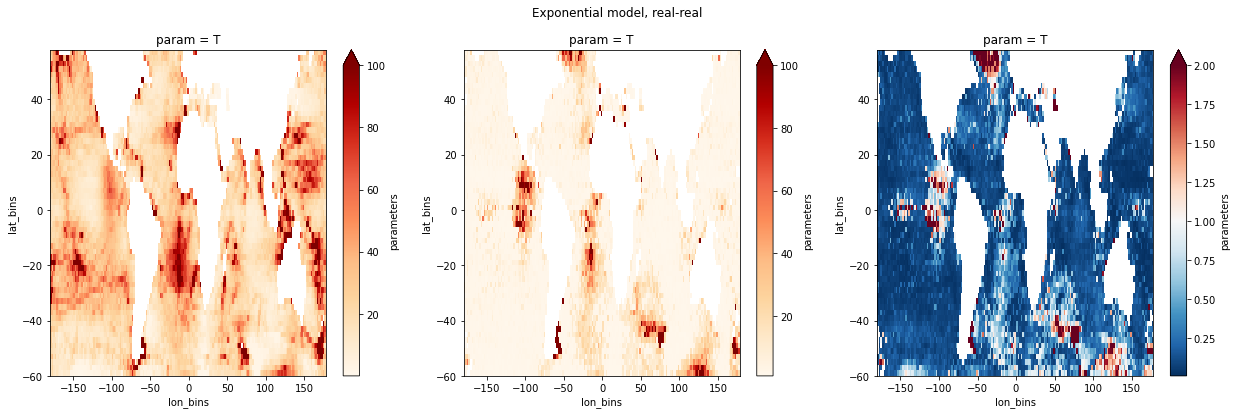

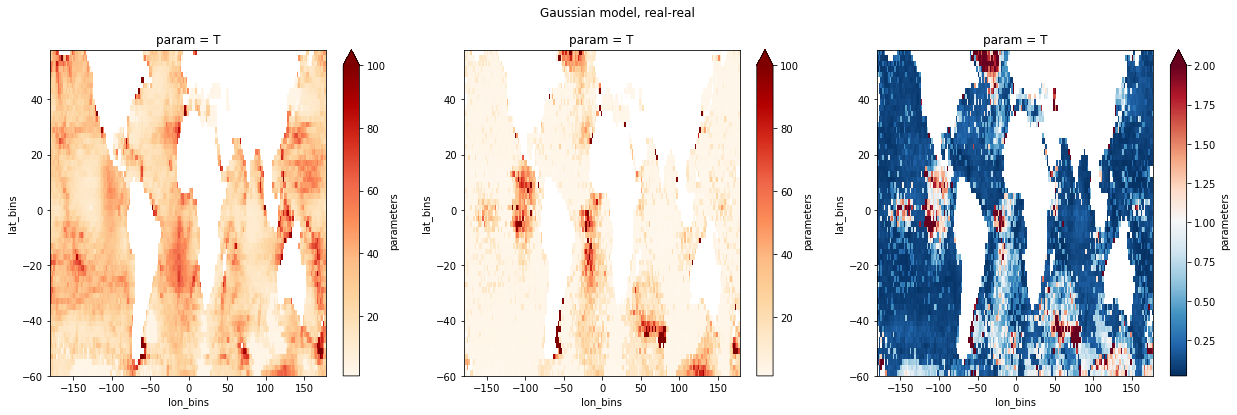

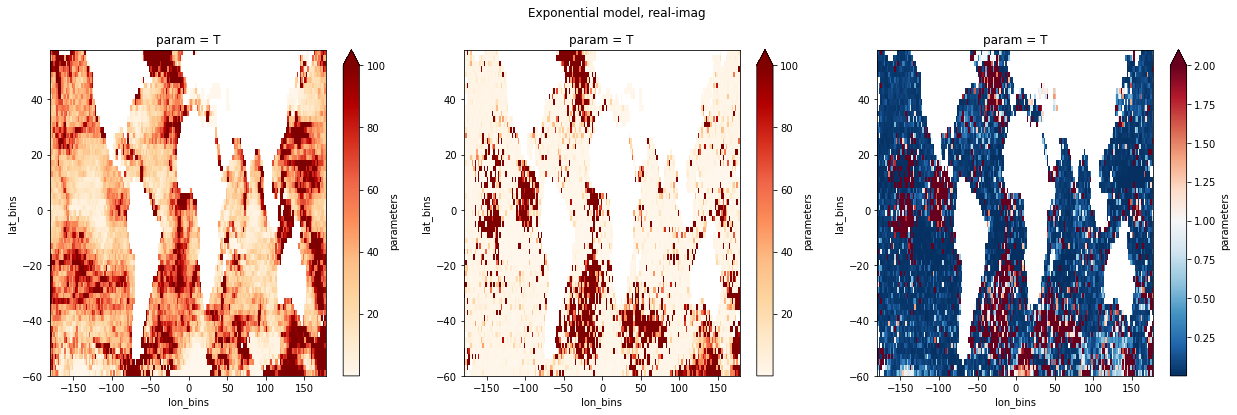

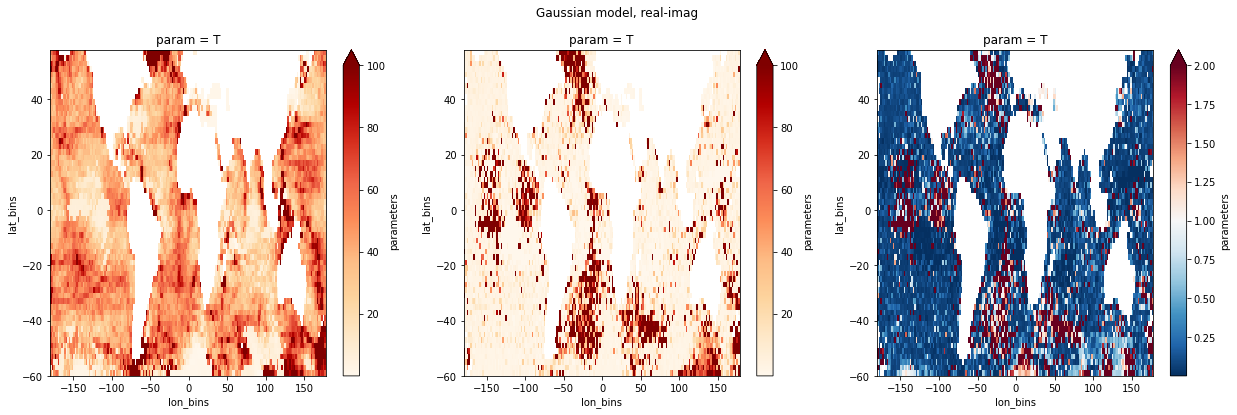

In [67]:
fig,ax = plot_parameters(dsE_out, dsL_out,'T',cmap='OrRd',vmax=100)
fig.suptitle('Exponential model, real-real')

fig,ax = plot_parameters(dsE_out_gauss, dsL_out_gauss,'T',cmap='OrRd',vmax=100)
fig.suptitle('Gaussian model, real-real')

fig,ax = plot_parameters(dsE_out_ri, dsL_out_ri,'T',cmap='OrRd',vmax=100)
fig.suptitle('Exponential model, real-imag')

fig,ax = plot_parameters(dsE_out_gauss_ri, dsL_out_gauss_ri,'T',cmap='OrRd',vmax=100)
fig.suptitle('Gaussian model, real-imag')

Text(0.5, 0.98, 'Gaussian model, real-imag')

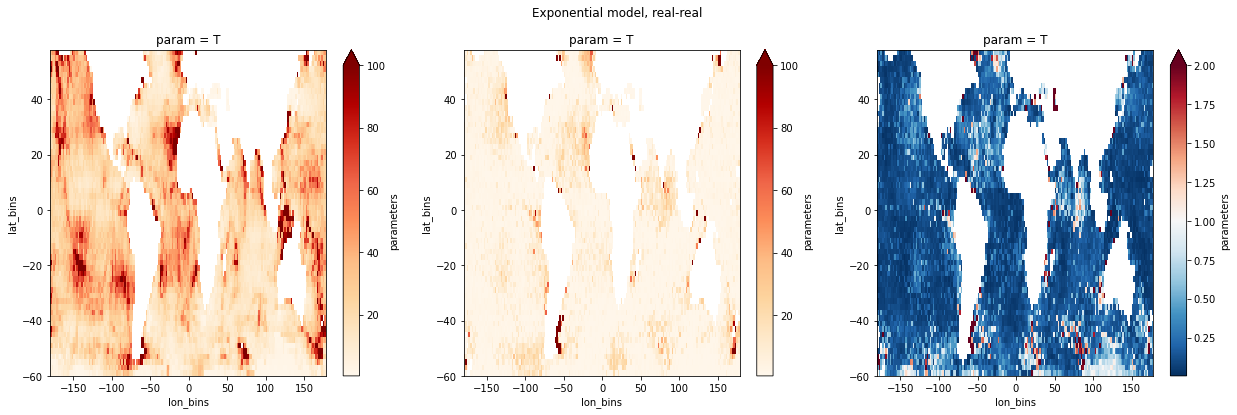

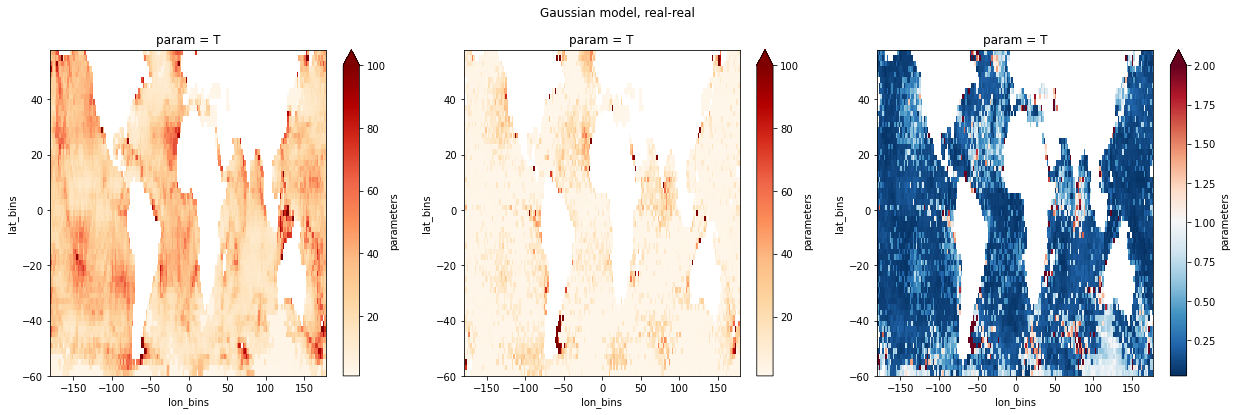

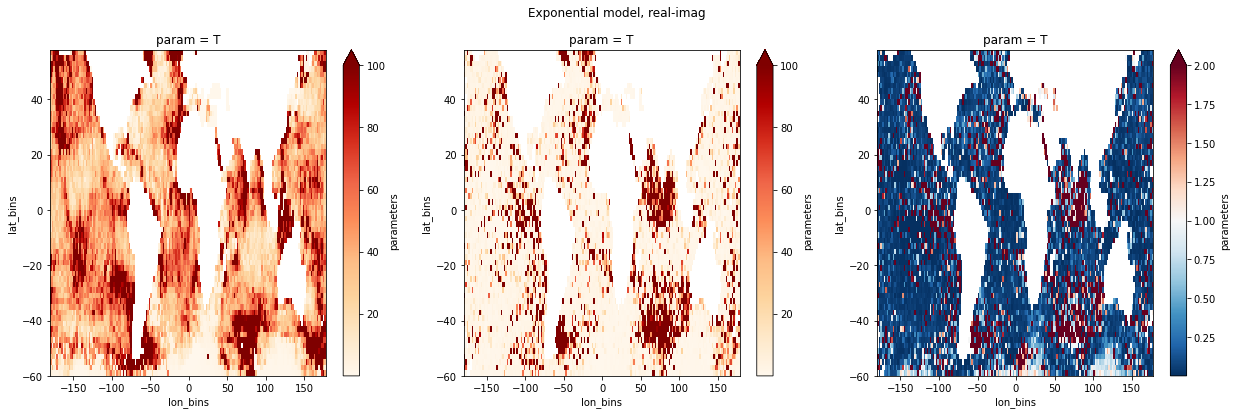

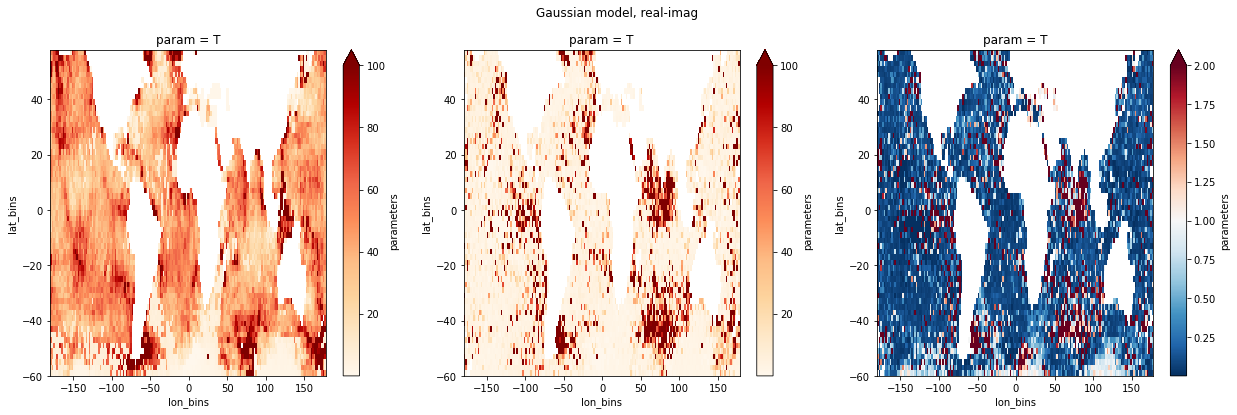

In [68]:
fig,ax = plot_parameters(dsEV_out, dsLV_out,'T',cmap='OrRd',vmax=100)
fig.suptitle('Exponential model, real-real')

fig,ax = plot_parameters(dsEV_out_gauss, dsLV_out_gauss,'T',cmap='OrRd',vmax=100)
fig.suptitle('Gaussian model, real-real')

fig,ax = plot_parameters(dsEV_out_ri, dsLV_out_ri,'T',cmap='OrRd',vmax=100)
fig.suptitle('Exponential model, real-imag')

fig,ax = plot_parameters(dsEV_out_gauss_ri, dsLV_out_gauss_ri,'T',cmap='OrRd',vmax=100)
fig.suptitle('Gaussian model, real-imag')

Text(0.5, 0.98, 'Exp/Gauss, real-imag')

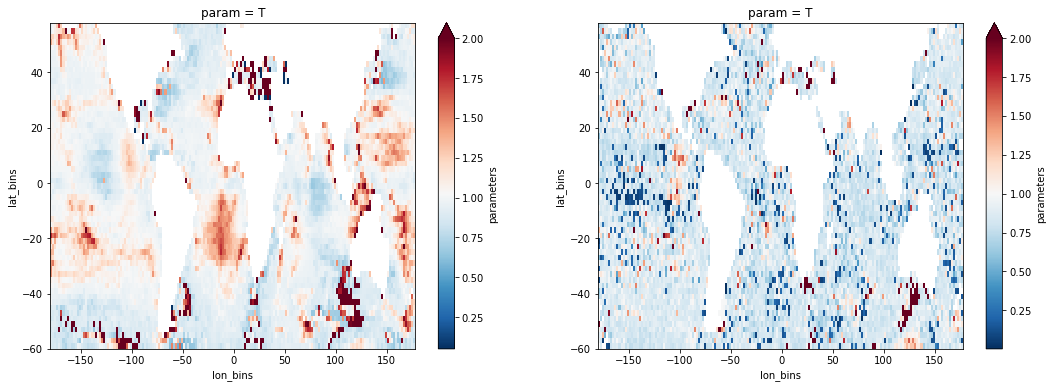

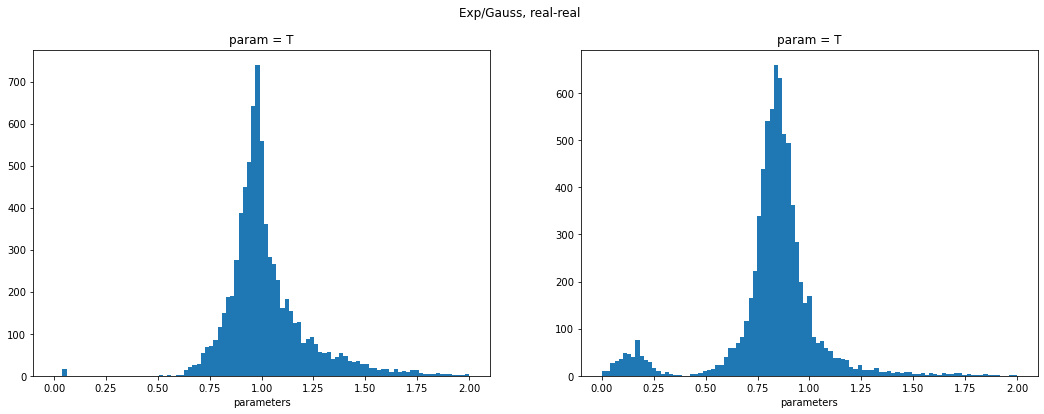

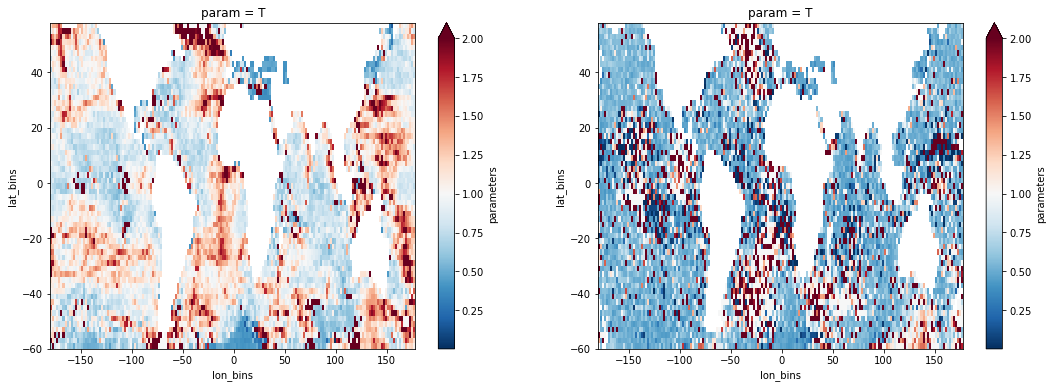

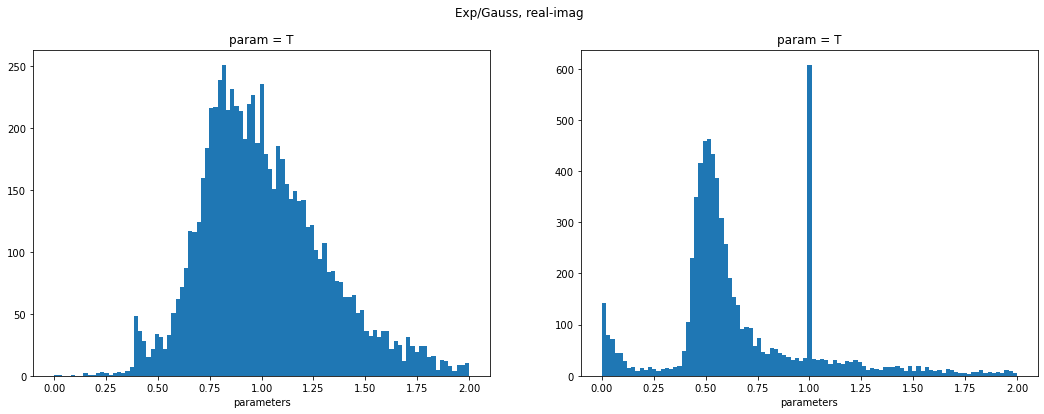

In [69]:
# Exponential vs gaussian :

bins = np.linspace(0,2,100)
fig,ax = plot_comparison([dsE_out,dsL_out], [dsE_out_gauss,dsL_out_gauss],'T',bins)
fig.suptitle('Exp/Gauss, real-real')
fig,ax = plot_comparison([dsE_out_ri,dsL_out_ri], [dsE_out_gauss_ri,dsL_out_gauss_ri],'T',bins)
fig.suptitle('Exp/Gauss, real-imag')

Text(0.5, 0.98, 'Exp/Gauss, real-imag')

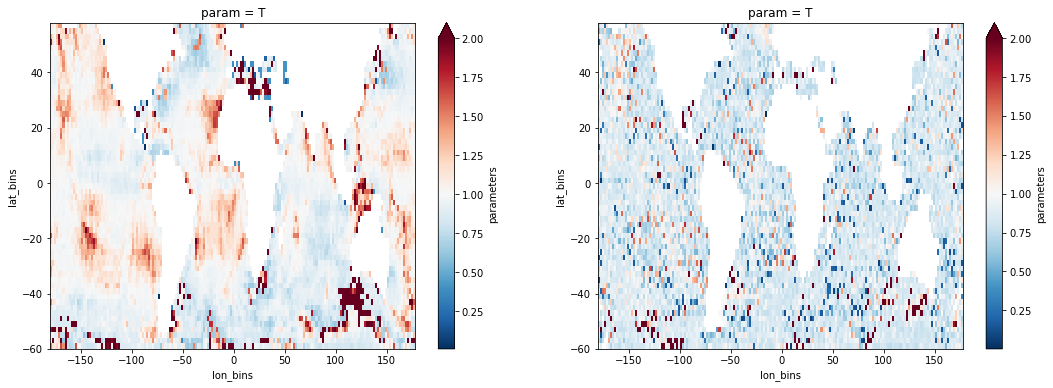

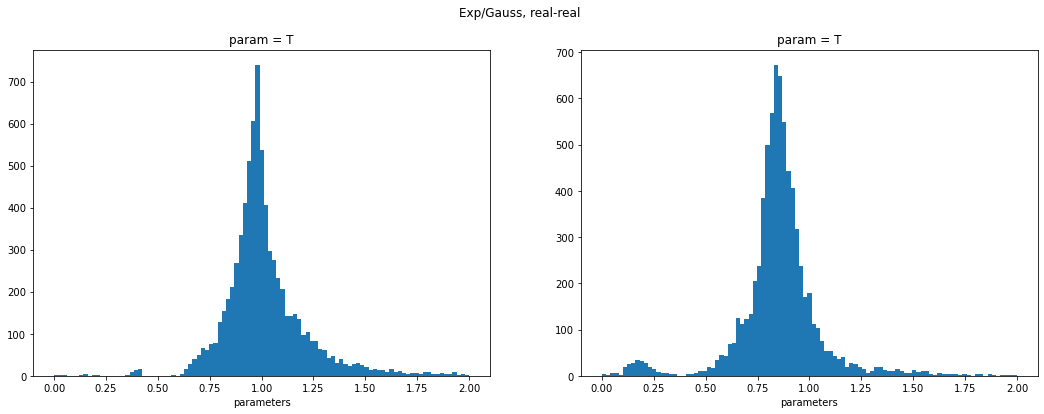

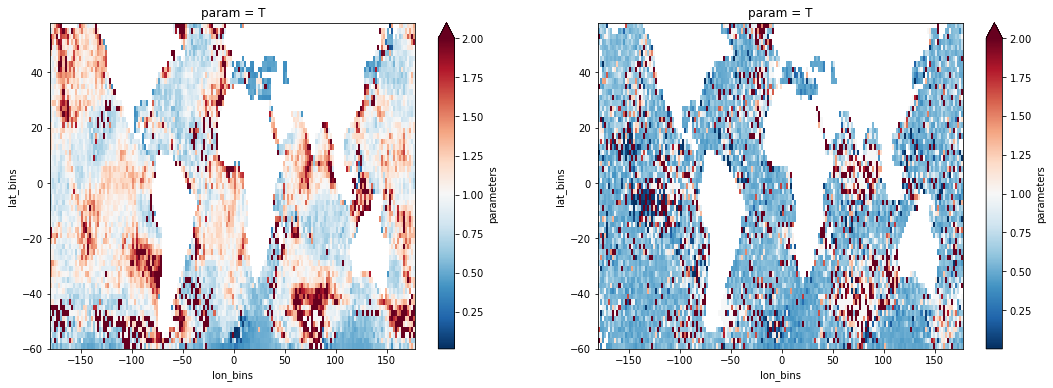

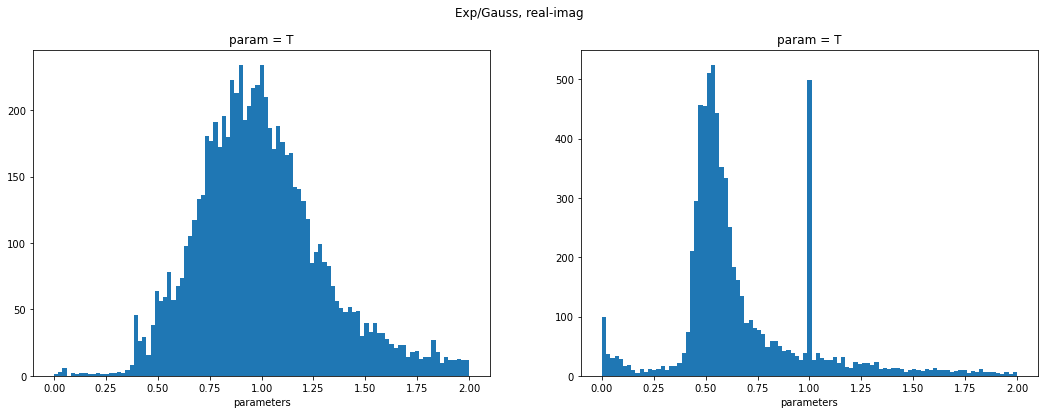

In [70]:
fig,ax = plot_comparison([dsEV_out,dsLV_out], [dsEV_out_gauss,dsLV_out_gauss],'T',bins)
fig.suptitle('Exp/Gauss, real-real')
fig,ax = plot_comparison([dsEV_out_ri,dsLV_out_ri], [dsEV_out_gauss_ri,dsLV_out_gauss_ri],'T',bins)
fig.suptitle('Exp/Gauss, real-imag')

Text(0.5, 0.98, 'rr/ri, gaussian')

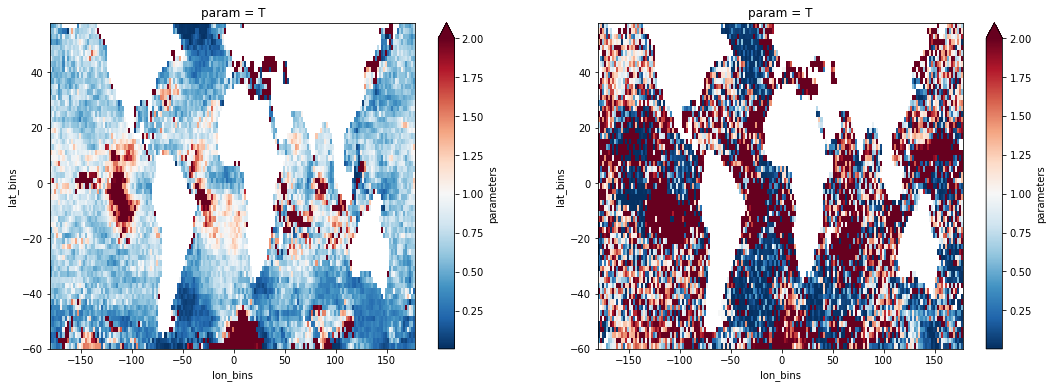

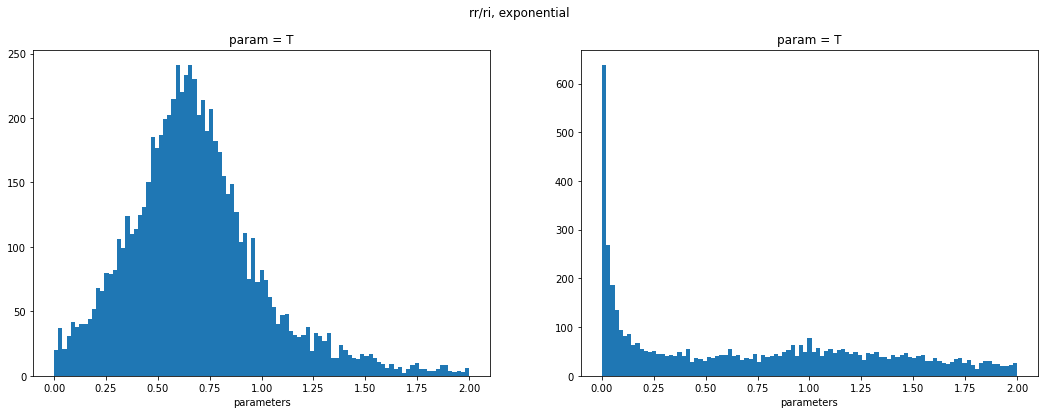

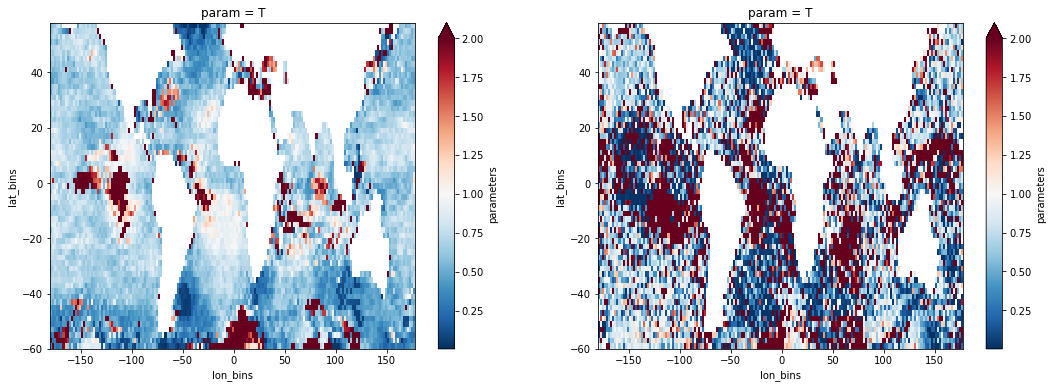

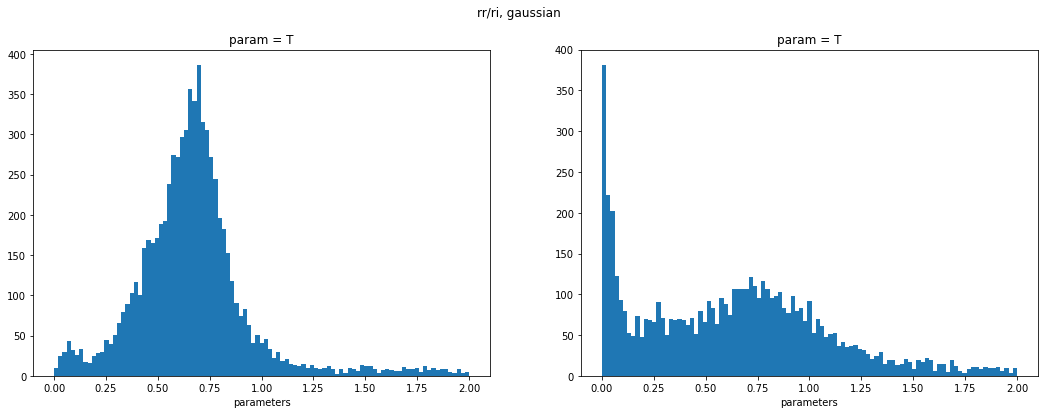

In [72]:
# rr vs ri :

bins = np.linspace(0,2,100)
fig,ax = plot_comparison([dsE_out,dsL_out], [dsE_out_ri,dsL_out_ri],'T',bins)
fig.suptitle('rr/ri, exponential')
fig,ax = plot_comparison([dsE_out_gauss,dsL_out_gauss], [dsE_out_gauss_ri,dsL_out_gauss_ri],'T',bins)
fig.suptitle('rr/ri, gaussian')

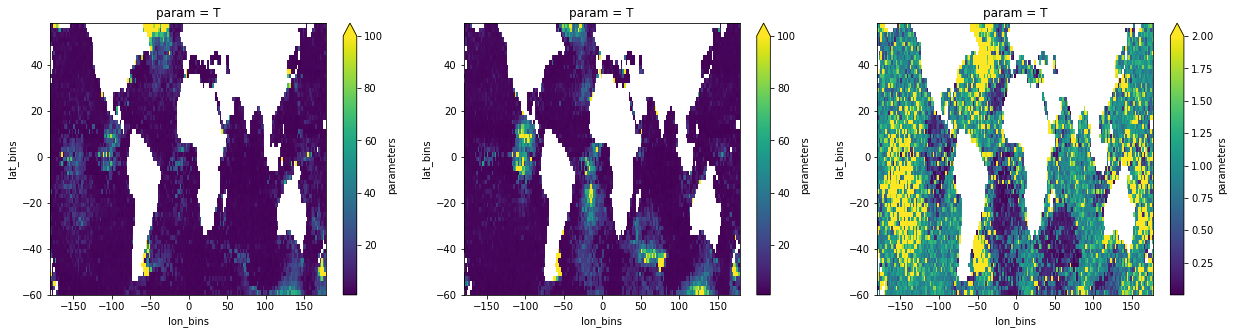

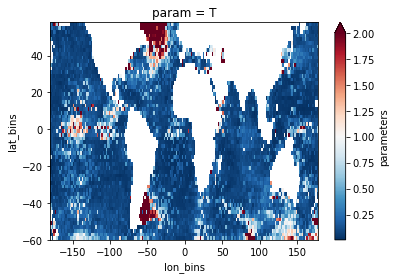

In [83]:
fig,ax = plt.subplots(1,3,figsize=(7*3,5))
dsL_out_ii.sel(param='T').parameters.plot(ax=ax[0],vmax=100)
dsL_out.sel(param='T').parameters.plot(ax=ax[1],vmax=100)
(dsL_out_ii/dsL_out).sel(param='T').parameters.plot(ax=ax[2],vmax=2)

plt.figure()
(dsL_out_ii/dsE_out).sel(param='T').parameters.plot(vmax=2,cmap='RdBu_r')

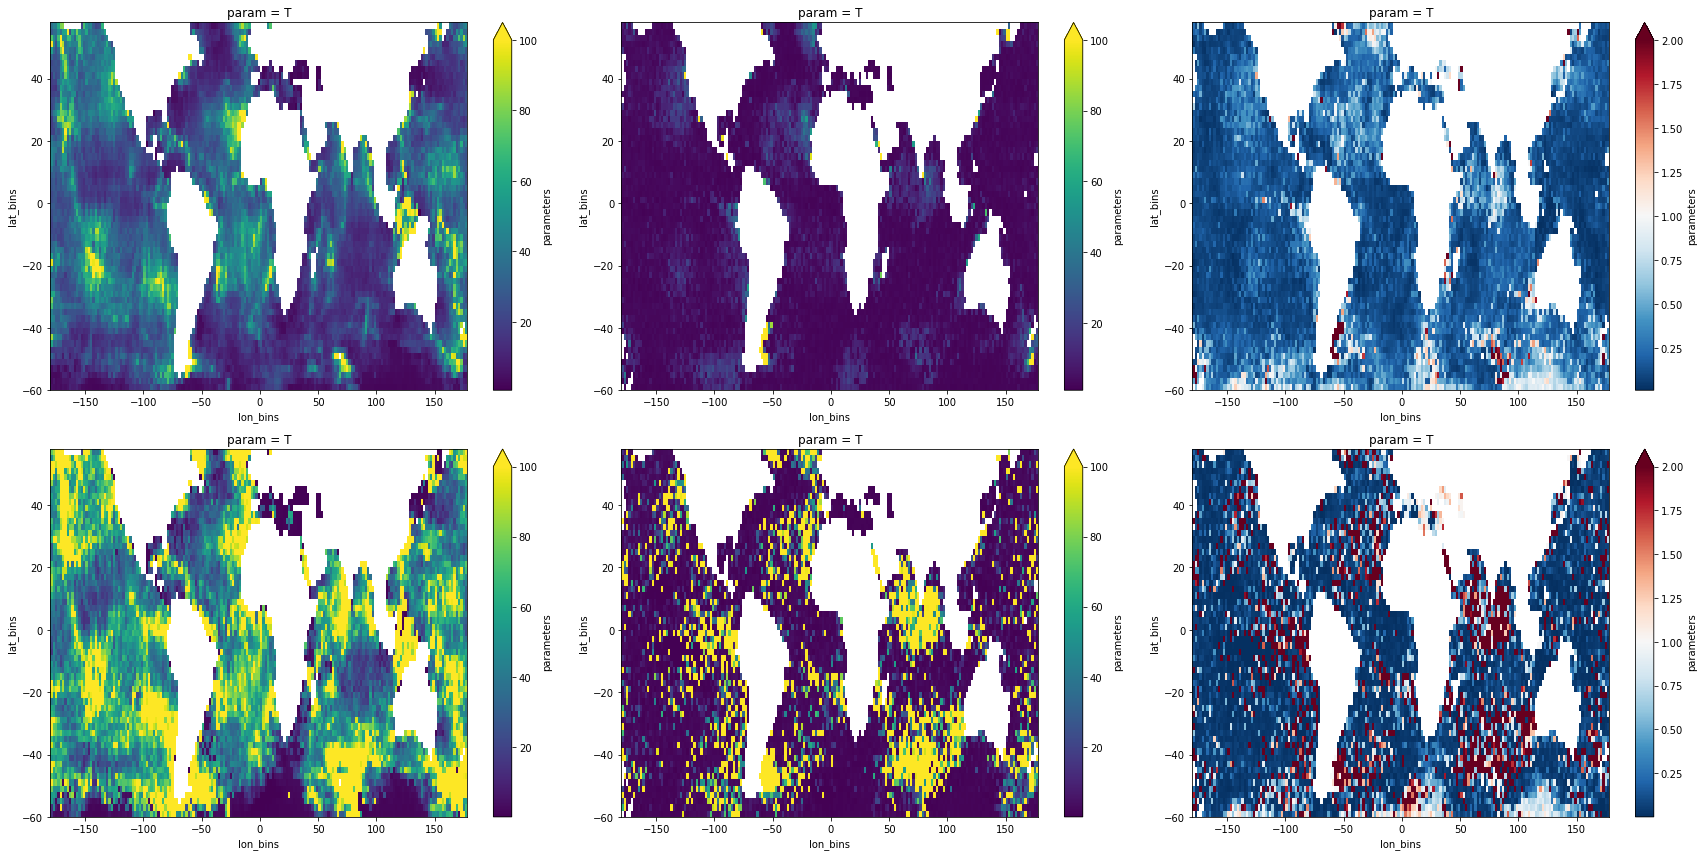

In [80]:
fig,axs = plt.subplots(2,3,figsize=(24,12))
dsEV_out.sel(param='T').parameters.plot(y='lat_bins',vmax=100,ax=axs[0,0])
dsLV_out.sel(param='T').parameters.plot(y='lat_bins',vmax=100,ax=axs[0,1])
(dsLV_out/dsEV_out).sel(param='T').parameters.plot(y='lat_bins',vmax=2,ax=axs[0,2],cmap='RdBu_r')

dsEV_out_ri.sel(param='T').parameters.plot(y='lat_bins',vmax=100,ax=axs[1,0])
dsLV_out_ri.sel(param='T').parameters.plot(y='lat_bins',vmax=100,ax=axs[1,1])
(dsLV_out_ri/dsEV_out_ri).sel(param='T').parameters.plot(y='lat_bins',vmax=2,ax=axs[1,2],cmap='RdBu_r')
fig.tight_layout()

In [85]:
def merge_fit(ds,dsV):
    """
    Returns merged dataset with best fit, corresponding paramters and their quadratic error for SSU and SSV.
    """
    dsV = dsV.rename({'parameters':'parameters_SSV','error':'error_SSV'})
    ds = ds.rename({'parameters':'parameters_SSU','error':'error_SSU'})
    ds = xr.merge([ds,dsV])
    return ds

In [86]:
# Save netcdf
dsE_out = merge_fit(dsE_out,dsEV_out)
dsL_out = merge_fit(dsL_out,dsLV_out)

In [87]:
dsE_out_gauss = merge_fit(dsE_out_gauss,dsEV_out_gauss)
dsL_out_gauss = merge_fit(dsL_out_gauss,dsLV_out_gauss)

dsE_out_ri = merge_fit(dsE_out_ri,dsEV_out_ri)
dsL_out_ri = merge_fit(dsL_out_ri,dsLV_out_ri)
#dsL_out_ri = merge_fit(dsL_out_ri,dsLV_out_ri)
dsE_out_gauss_ri = merge_fit(dsE_out_gauss_ri,dsEV_out_gauss_ri)
dsL_out_gauss_ri = merge_fit(dsL_out_gauss_ri,dsLV_out_gauss_ri)

In [88]:
dsL_out

<xarray.Dataset>
Dimensions:         (lat_bins: 59, lon_bins: 179, param: 2, lags: 321)
Coordinates:
  * lat_bins        (lat_bins) float64 -59.0 -57.0 -55.0 ... 53.0 55.0 57.0
  * lon_bins        (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0
  * param           (param) <U1 'U' 'T'
  * lags            (lags) float64 0.0 0.125 0.25 0.375 ... 39.75 39.88 40.0
Data variables:
    parameters_SSU  (lat_bins, lon_bins, param) float64 nan nan ... 8.206
    error_SSU       (lat_bins, lon_bins, param) float64 nan nan ... 0.136 212.2
    rr_SSU          (lat_bins, lon_bins, lags) float64 nan nan ... -4.355e-05
    parameters_SSV  (lat_bins, lon_bins, param) float64 nan nan ... 7.723
    error_SSV       (lat_bins, lon_bins, param) float64 nan nan ... 0.1387 213.3
    rr_SSV          (lat_bins, lon_bins, lags) float64 nan nan ... -3.1e-05

In [91]:
dsE_out.to_netcdf('/Users/zcaspar/codes/mit4320/E_hf_fit.nc')
dsL_out.to_netcdf('/Users/zcaspar/codes/mit4320/L_hf_fit.nc')
dsL_out_ii.to_netcdf('/Users/zcaspar/codes/mit4320/L_hf_fit_ii.nc')
dsE_out_gauss.to_netcdf('/Users/zcaspar/codes/mit4320/E_hf_fit_gauss.nc')
dsL_out_gauss.to_netcdf('/Users/zcaspar/codes/mit4320/L_hf_fit_gauss.nc')

dsE_out_ri.to_netcdf('/Users/zcaspar/codes/mit4320/E_hf_fit_ri.nc')
dsL_out_ri.to_netcdf('/Users/zcaspar/codes/mit4320/L_hf_fit_ri.nc')

dsE_out_gauss_ri.to_netcdf('/Users/zcaspar/codes/mit4320/E_hf_fit_gauss_ri.nc')
dsL_out_gauss_ri.to_netcdf('/Users/zcaspar/codes/mit4320/L_hf_fit_gauss_ri.nc')
#dsL_out_gauss.to_netcdf('/Users/zcaspar/codes/mit4320/L_hf_fit_gauss.nc')

### Double constraints : simultaneous fit

In [249]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def comboFunc(comboData, U, T):
        # single data set passed in, extract separate data
    extract1 = comboData[:len(y1)] # first data
    extract2 = comboData[len(y2):] # second data

    result1 = mod1(extract1, U, T)
    result2 = mod2(extract2, U, T)

    return np.append(result1, result2)

def fit_combined(y1,y2,h=None,sigma=None,bounds=None):
    comboY = np.append(y1, y2)
    comboX = np.append(h, h)
    # some initial parameter values
    initialParameters = np.array([1.0, 40.0])
#    print(sigma)
    try:
        # curve fit the combined data to the combined function
        fittedParameters, pcov = curve_fit(comboFunc, comboX, comboY, initialParameters,
                                           bounds=bounds)#, sigma=sigma, absolute_sigma=True)
        # values for display of fitted function
        U, T = fittedParameters
        y_fit_1 = mod1(h, U, T) # first data set, first equation
        y_fit_2 = mod2(h, U, T) # second data set, second equation
    except:
        #print(curve_fit(comboFunc, comboX, comboY, initialParameters,
        #                                   bounds=bounds, sigma=sigma, absolute_sigma=True))
     #   print(sigma.size)
        U,T = np.nan,np.nan
    return np.array([U,T])


In [244]:
def mod1(data, U, T): 
    return U * np.exp(-(data/T)**2) * np.cos(2*np.pi*omega_sn*data)

def mod2(data, U, T): 
    return U * np.exp(-(data/T)**2) * np.sin(2*np.pi*omega_sn*data)

In [247]:
sigma = np.ones(tau.size)
bounds = ([0,0],[np.inf,1000])
kwargs = {'h':tau,'sigma':sigma,'bounds':bounds}
dsE_combined = xr.apply_ufunc(fit_combined,dsE.rr_SSU, dsE.ri_SSU
                              ,input_core_dims=[['lags'],['lags']],output_core_dims=[['param']]
                              ,vectorize=True,kwargs=kwargs
                             ).assign_coords({'param':['U','T']})

321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321


321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321
321


In [254]:
dsL_combined = xr.apply_ufunc(fit_combined,dsL.rr_SSU, dsL.ri_SSU
                              ,input_core_dims=[['lags'],['lags']],output_core_dims=[['param']]
                              ,vectorize=True,kwargs={'h':tau,'bounds':bounds}
                             ).assign_coords({'param':['U','T']})

In [251]:
dsE_out = xr.open_dataset('/Users/zcaspar/codes/mit4320/E_hf_fit_gauss.nc')
dsL_out = xr.open_dataset('/Users/zcaspar/codes/mit4320/L_hf_fit_gauss.nc')

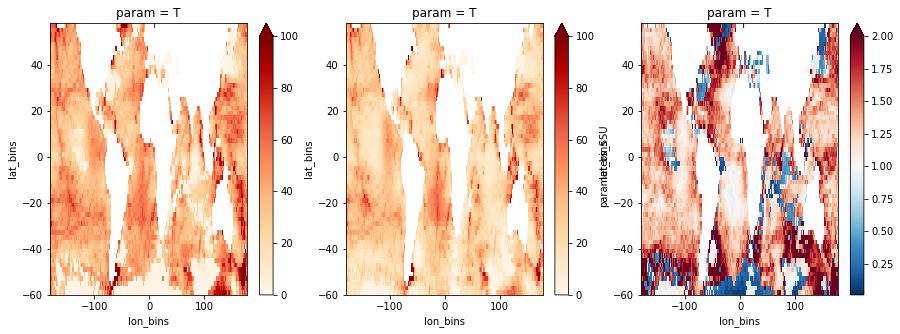

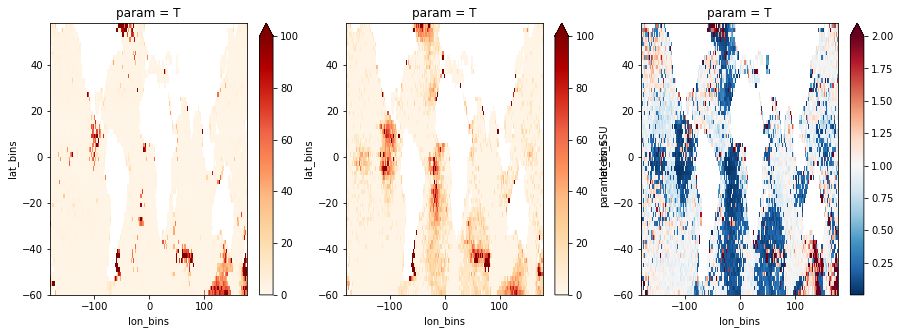

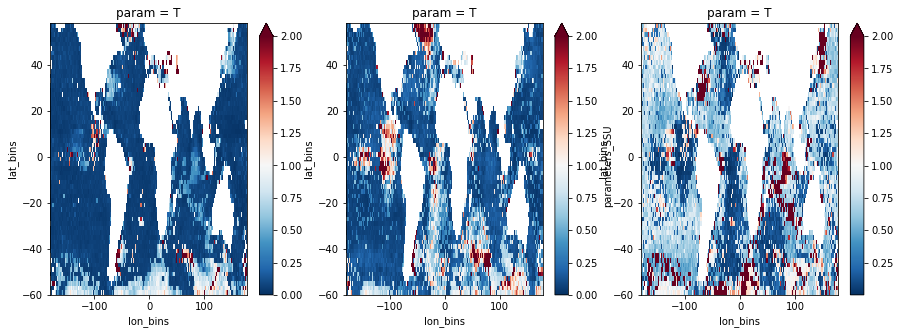

In [256]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
(dsE_combined).sel(param='T').plot(vmax=100,vmin=0,y='lat_bins',cmap='OrRd',ax=axs[0])
(dsE_out.parameters_SSU).sel(param='T').plot(vmax=100,vmin=0,y='lat_bins',cmap='OrRd',ax=axs[1])
(dsE_combined/dsE_out.parameters_SSU).sel(param='T').plot(vmax=2,y='lat_bins',cmap='RdBu_r',ax=axs[2])

fig,axs = plt.subplots(1,3,figsize=(15,5))
(dsL_combined).sel(param='T').plot(vmax=100,vmin=0,y='lat_bins',cmap='OrRd',ax=axs[0])
(dsL_out.parameters_SSU).sel(param='T').plot(vmax=100,vmin=0,y='lat_bins',cmap='OrRd',ax=axs[1])
(dsL_combined/dsL_out.parameters_SSU).sel(param='T').plot(vmax=2,y='lat_bins',cmap='RdBu_r',ax=axs[2])

fig,axs = plt.subplots(1,3,figsize=(15,5))
(dsL_combined/dsE_combined).sel(param='T').plot(vmax=2,vmin=0,y='lat_bins',cmap='RdBu_r',ax=axs[0])
(dsL_out.parameters_SSU/dsE_out.parameters_SSU
).sel(param='T').plot(vmax=2,vmin=0,y='lat_bins',cmap='RdBu_r',ax=axs[1])
(dsE_out.parameters_SSU*dsL_combined/(dsE_combined*dsL_out.parameters_SSU)
).sel(param='T').plot(vmax=2,y='lat_bins',cmap='RdBu_r',ax=axs[2])

In [257]:
def mod1(data, U, T): 
    return U * np.exp(-(data/T)**2) * np.cos(2*np.pi*omega_sn*data)

def mod2(data, U, T): 
    return U * np.exp(-(data/T)**2) * np.cos(2*np.pi*omega_sn*data)

dsL_combined_ii = xr.apply_ufunc(fit_combined,dsL.rr_SSU, dsL.ii_SSU
                              ,input_core_dims=[['lags'],['lags']],output_core_dims=[['param']]
                              ,vectorize=True,kwargs={'h':tau,'bounds':bounds}
                             ).assign_coords({'param':['U','T']})

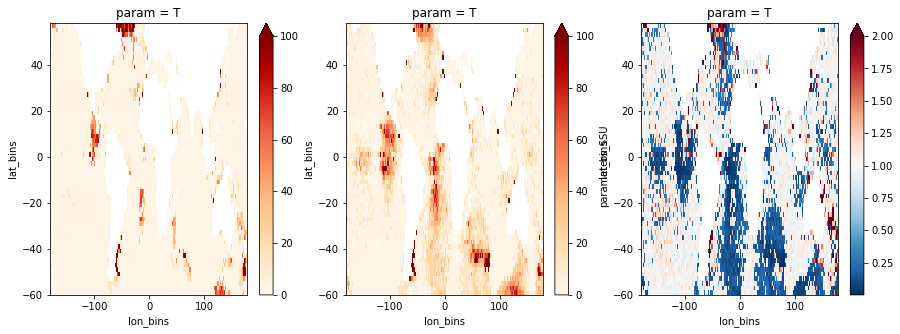

In [258]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
(dsL_combined_ii).sel(param='T').plot(vmax=100,vmin=0,y='lat_bins',cmap='OrRd',ax=axs[0])
(dsL_out.parameters_SSU).sel(param='T').plot(vmax=100,vmin=0,y='lat_bins',cmap='OrRd',ax=axs[1])
(dsL_combined_ii/dsL_out.parameters_SSU).sel(param='T').plot(vmax=2,y='lat_bins',cmap='RdBu_r',ax=axs[2])

In [259]:
def mod1_fix(data, T, U=U): 
    return U * np.exp(-(data/T)**2) * np.cos(2*np.pi*omega_sn*data)

def mod2_fix(data, T, U=U): 
    return U * np.exp(-(data/T)**2) * np.sin(2*np.pi*omega_sn*data)

In [262]:
def comboFunc(comboData, U, T):
        # single data set passed in, extract separate data
    extract1 = comboData[:len(y1)] # first data
    extract2 = comboData[len(y2):] # second data

    result1 = mod1_fix(extract1, U, T)
    result2 = mod2_fix(extract2, U, T)

    return np.append(result1, result2)
def fit_combined_fix(y1,y2,h=None,sigma=None,bounds=None):
    comboY = np.append(y1, y2)
    comboX = np.append(h, h)
    # some initial parameter values
    initialParameters = np.array([1.0, 40.0])
    u = y1[0]
#    print(sigma)
    try:
        # curve fit the combined data to the combined function
        fittedParameters, pcov = curve_fit(comboFunc, comboX, comboY, initialParameters,
                                           bounds=bounds)#, sigma=sigma, absolute_sigma=True)
        # values for display of fitted function
        U, T = fittedParameters
        y_fit_1 = mod1_fix(h, T, U=u) # first data set, first equation
        y_fit_2 = mod2_fix(h, T, U=u) # second data set, second equation
    except:
        #print(curve_fit(comboFunc, comboX, comboY, initialParameters,
        #                                   bounds=bounds, sigma=sigma, absolute_sigma=True))
     #   print(sigma.size)
        U,T = np.nan,np.nan
    return np.array([U,T])

In [263]:
bounds = (0,1000)
kwargs = {'h':tau,'sigma':sigma,'bounds':bounds}
dsE_combined = xr.apply_ufunc(fit_combined_fix,dsE.rr_SSU, dsE.ri_SSU
                              ,input_core_dims=[['lags'],['lags']],output_core_dims=[['param']]
                              ,vectorize=True,kwargs=kwargs
                             ).assign_coords({'param':['U','T']})

In [264]:
dsL_combined = xr.apply_ufunc(fit_combined_fix,dsL.rr_SSU, dsL.ri_SSU
                              ,input_core_dims=[['lags'],['lags']],output_core_dims=[['param']]
                              ,vectorize=True,kwargs={'h':tau,'bounds':bounds}
                             ).assign_coords({'param':['U','T']})

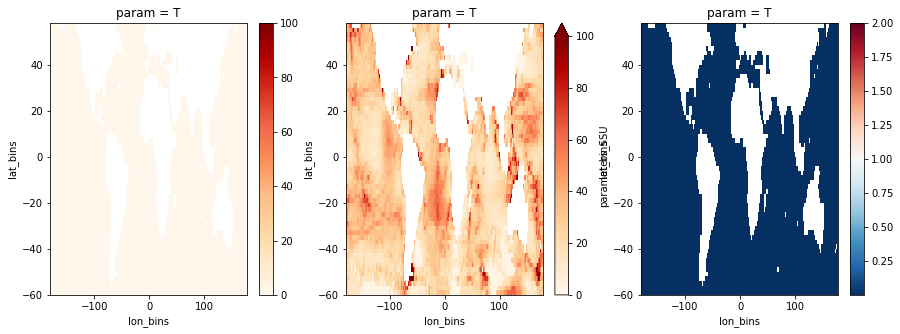

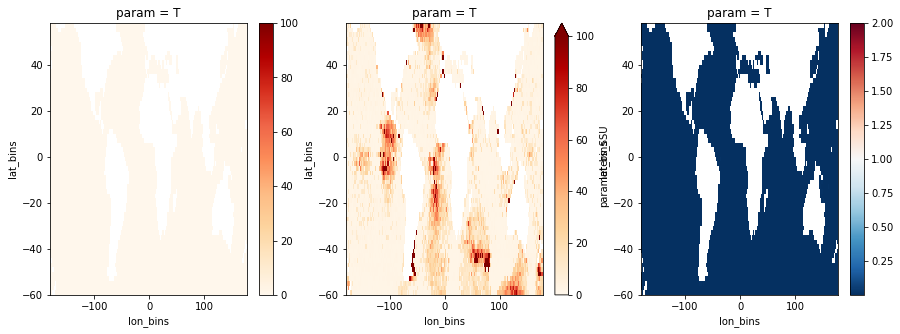

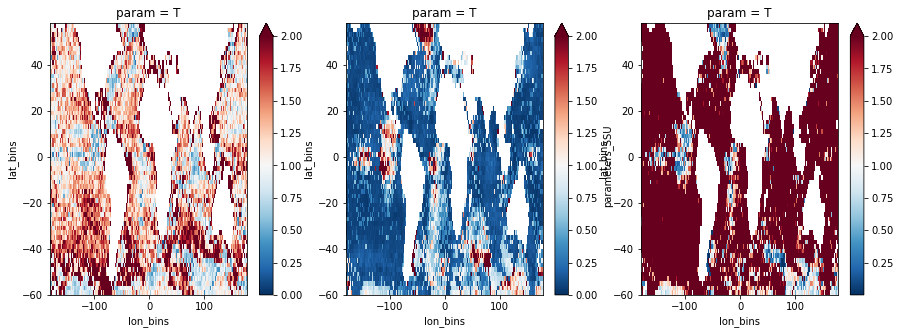

In [265]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
(dsE_combined).sel(param='T').plot(vmax=100,vmin=0,y='lat_bins',cmap='OrRd',ax=axs[0])
(dsE_out.parameters_SSU).sel(param='T').plot(vmax=100,vmin=0,y='lat_bins',cmap='OrRd',ax=axs[1])
(dsE_combined/dsE_out.parameters_SSU).sel(param='T').plot(vmax=2,y='lat_bins',cmap='RdBu_r',ax=axs[2])

fig,axs = plt.subplots(1,3,figsize=(15,5))
(dsL_combined).sel(param='T').plot(vmax=100,vmin=0,y='lat_bins',cmap='OrRd',ax=axs[0])
(dsL_out.parameters_SSU).sel(param='T').plot(vmax=100,vmin=0,y='lat_bins',cmap='OrRd',ax=axs[1])
(dsL_combined/dsL_out.parameters_SSU).sel(param='T').plot(vmax=2,y='lat_bins',cmap='RdBu_r',ax=axs[2])

fig,axs = plt.subplots(1,3,figsize=(15,5))
(dsL_combined/dsE_combined).sel(param='T').plot(vmax=2,vmin=0,y='lat_bins',cmap='RdBu_r',ax=axs[0])
(dsL_out.parameters_SSU/dsE_out.parameters_SSU
).sel(param='T').plot(vmax=2,vmin=0,y='lat_bins',cmap='RdBu_r',ax=axs[1])
(dsE_out.parameters_SSU*dsL_combined/(dsE_combined*dsL_out.parameters_SSU)
).sel(param='T').plot(vmax=2,y='lat_bins',cmap='RdBu_r',ax=axs[2])

In [25]:
from symfit import parameters, variables, Fit, Model, exp, cos, pi

In [160]:
dt = 3/24
sigma = np.full(xdata.size,1)
sigma[:int(20/dt)] = 0.5

# Define a model to fit to.
U, T = parameters('U, T')
x,y = variables('tau,y')
model = {y: U * exp( - (x/T)**2 ) * cos(2*pi*omega_sn*x)}

# Generate some data
xdata = tau #np.linspace(0, 100, 100)  # From 0 to 100 in 100 steps
#a_vec = np.random.normal(15.0, scale=2.0, size=(100,))
#b_vec = np.random.normal(100.0, scale=2.0, size=(100,))
# Point scattered around the line 5 * x + 105
ydata = dsL.rr_SSU.isel(lon_bins=10,lat_bins=10).values
#mean(['lon_bins','lat_bins']).values

fit = Fit(model, xdata, ydata)#,sigma_y=sigma,absolute_sigma=False)
fit_result = fit.execute()

In [157]:
np.isnan(ydata).any()==True

<xarray.DataArray 'rr_SSU' ()>
array(True)
Coordinates:
    lat_bins  float64 -59.0
    lon_bins  float64 -179.0

In [161]:
fit_result.params["T"]

2.154001356816678

In [60]:
def yfit(x,U,T):
    return U * np.exp( - (x/T)**2 ) * np.cos(2*np.pi*omega_sn*x)

In [165]:
def fit_symfit(ydata,t=None):
    U, T = parameters('U, T')
    x,y = variables('tau,y')
    model = {y: U * exp( - (x/T)**2 ) * cos(2*pi*omega_sn*x)}
    xdata = t
    if np.isnan(ydata).any()==True:
        out = np.array([np.nan,np.nan])
    else:
        fit = Fit(model, xdata, ydata)#,sigma_y=sigma,absolute_sigma=False)
        fit_result = fit.execute()
    #    print(fit_result.params['T'],fit_result.params['U'])
        out = np.array([fit_result.params['T'],fit_result.params['U']])
    return out


In [117]:
for i in range(dsE.lon_bins.size):
    if dsE.rr_SSU.isel(lon_bins=i).any()==np.nan:
        print('Aaaaah')

In [138]:
dsL

<xarray.Dataset>
Dimensions:   (lat_bins: 59, lon_bins: 179, lags: 321)
Coordinates:
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lags      (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0
Data variables:
    rr_SSU    (lat_bins, lon_bins, lags) float64 nan nan ... -0.0002552
    ri_SSU    (lat_bins, lon_bins, lags) float64 nan nan ... -0.0004139
    ii_SSU    (lat_bins, lon_bins, lags) float64 nan nan ... 0.0002616 0.0002871
    count     (lat_bins, lon_bins) float64 0.0 1.0 0.0 0.0 ... 14.0 11.0 14.0
    rr_SSV    (lat_bins, lon_bins, lags) float64 nan nan ... 0.0001015 0.0001135
    ri_SSV    (lat_bins, lon_bins, lags) float64 nan nan ... -0.0004687

In [174]:
test = xr.apply_ufunc(fit_symfit,dsE.rr_SSU#.isel(lon_bins=slice(0,None,10))
               ,input_core_dims=[['lags']],output_core_dims=[['param']]
               ,vectorize=True,kwargs={'t':tau})

In [175]:
test = test.assign_coords({'param':['T','U']})

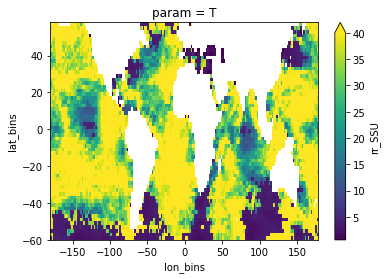

In [178]:
test.sel(param='T').plot(vmax=40,y='lat_bins')

In [183]:
testL = xr.apply_ufunc(fit_symfit,dsL.rr_SSU#.isel(lon_bins=slice(0,None,10))
               ,input_core_dims=[['lags']],output_core_dims=[['param']]
               ,vectorize=True,kwargs={'t':tau})

In [184]:
testL = testL.assign_coords({'param':['T','U']})

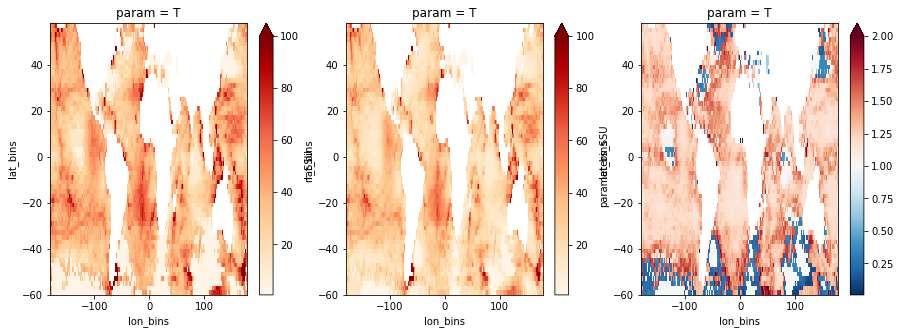

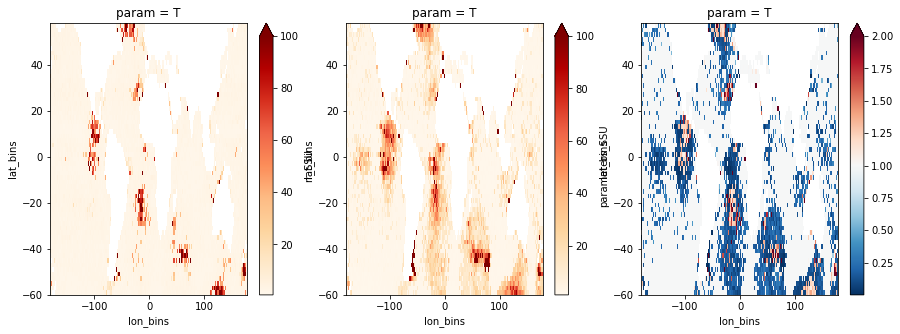

In [186]:

fig,axs = plt.subplots(1,3,figsize=(15,5))
(test).sel(param='T').plot(vmax=100,y='lat_bins',cmap='OrRd',ax=axs[0])
(dsE_out.parameters_SSU).sel(param='T').plot(vmax=100,y='lat_bins',cmap='OrRd',ax=axs[1])
(test/dsE_out.parameters_SSU).sel(param='T').plot(vmax=2,y='lat_bins',cmap='RdBu_r',ax=axs[2])

fig,axs = plt.subplots(1,3,figsize=(15,5))
(testL).sel(param='T').plot(vmax=100,y='lat_bins',cmap='OrRd',ax=axs[0])
(dsL_out.parameters_SSU).sel(param='T').plot(vmax=100,y='lat_bins',cmap='OrRd',ax=axs[1])
(testL/dsL_out.parameters_SSU).sel(param='T').plot(vmax=2,y='lat_bins',cmap='RdBu_r',ax=axs[2])
#(testL/dsL_out.parameters_SSU).sel(param='T').plot(vmax=2,y='lat_bins',cmap='RdBu_r')

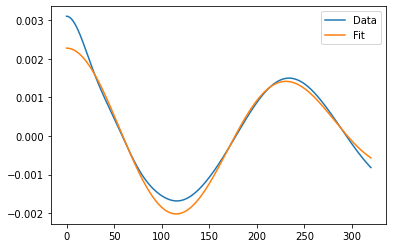

In [61]:
plt.plot(ydata,label='Data')
plt.plot(yfit(xdata,fit_result.params['U'],fit_result.params['T']),label='Fit')
plt.legend()

In [78]:
xr.apply_ufunc(Fit,ds[v],input_core_dims=[['lags']],
                                   output_core_dims=[['param']],
                                   vectorize=True,kwargs=kwargs)

NameError: name 'ds' is not defined

In [27]:
def fit_function(y,model,t=None,bounds=None,sigma=None):
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        y : data to fit
        t : timelag of the correlation function
        myfunc : function we want to fit to our data, y
        p0 : first guess on parameters
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        params : parameters for which we obtain the best fit
        error : covariance of params computed in scipy.optimize.curve_fit
        yfit : best fit
        """
    U, T = parameters('U, T')
x, = variables('tau')
model = {y: U * exp( - (x/T)**2 ) * cos(2*pi*omega_sn*x)}
    try : 
        if first_guess=='lag' and sigma is None:
            _p0 = np.full(len_sig-1,1)
            _p0[-1] = y[0]
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000)
    #    try:
        if sigma is not None:
            if first_guess=='lag':
                _p0 = np.full(len_sig-1,1)
                _p0[-1] = y[0]
                params = scipy.optimize.curve_fit(myfunc,t,y,p0=_p0,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
            else:
                params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000,
                                                  sigma=sigma,absolute_sigma=True)
        else:
            params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds,maxfev=1000)
        yfit = myfunc(t,*[p for p in params])
        error=np.sqrt(np.diag(cov))
    except:
#        print("error")
        params,error = np.full(len_sig-1,np.nan),np.full(len_sig-1,np.nan)
        yfit = np.full_like(t,np.nan)
#        out = xr.Dataset({'params':(['lat_bins','lon_bins','param'],np.expand_dims(params, axis=0)),
#                      'fitted':(['lat_bins','lon_bins','lags'],np.expand_dims(yfit,axis=0)),
#                     'error' : (['lat_bins','lon_bins','param'],np.expand_dims(cov,axis=0))},
 #                    coords={'lat_bins':np.array([y.lat_bins.values]),'lon_bins':np.array([y.lon_bins.values])
 #                            ,'param':[V for V in sig.parameters.keys()][1:],
 #                            'lags':y.lags.values})
    return params,error,yfit

def wrapper(ds,v,myfunc,t,bounds,p0='free',sigma=None):
    sig = signature(myfunc)
    params_name = [V for V in sig.parameters.keys()][1:]
    kwargs={'t':t,'myfunc':myfunc,'first_guess':p0,'bounds':bounds}
    if sigma is not None:
        kwargs.update({'sigma':sigma})
        
    print('Parameters to estimate:',params_name)
    params,error,yfit = xr.apply_ufunc(fit_function,ds[v],input_core_dims=[['lags']],
                                   output_core_dims=[['param'],['param'],['lags']],
                                   vectorize=True,kwargs=kwargs)
    params = params.rename('parameters').assign_coords({'param':params_name})
    error = error.rename('error').assign_coords({'param':params_name})
    ds_out = xr.merge([params,error,yfit])
#    ds_out = ds_out.where(ds_out[v].isel(lags=0)>1e-18)
    return ds_out

In [29]:
model

{y: U*exp(-x/T)*cos(0.0677263857327552*pi*x)}